# Content table

1. Client
2. Server

## Installing dependencies

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import datetime
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

import flwr as fl
from torchsummary import summary
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import color
import os
import multiprocessing as mp
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cores = mp.cpu_count()
c = color.clr()
print(c.SUCCESS('Day:'), datetime.datetime.now())
print(c.SUCCESS('Device:'), device)
print(c.SUCCESS('Core:'), cores)

Day: 2023-05-26 13:58:51.346433
Device: cuda
Core: 8


# 1. Setup client

Epoch 1/2
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, acc=0.812, loss=0.635]


Train Loss: 0.6656 - Train Acc: 0.7248
Val Loss: 0.6225 - Val Acc: 0.8750
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 2/2
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s, acc=0.812, loss=0.589]


Train Loss: 0.6033 - Train Acc: 0.8333
Val Loss: 0.5641 - Val Acc: 0.8750
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Training and validation completed!


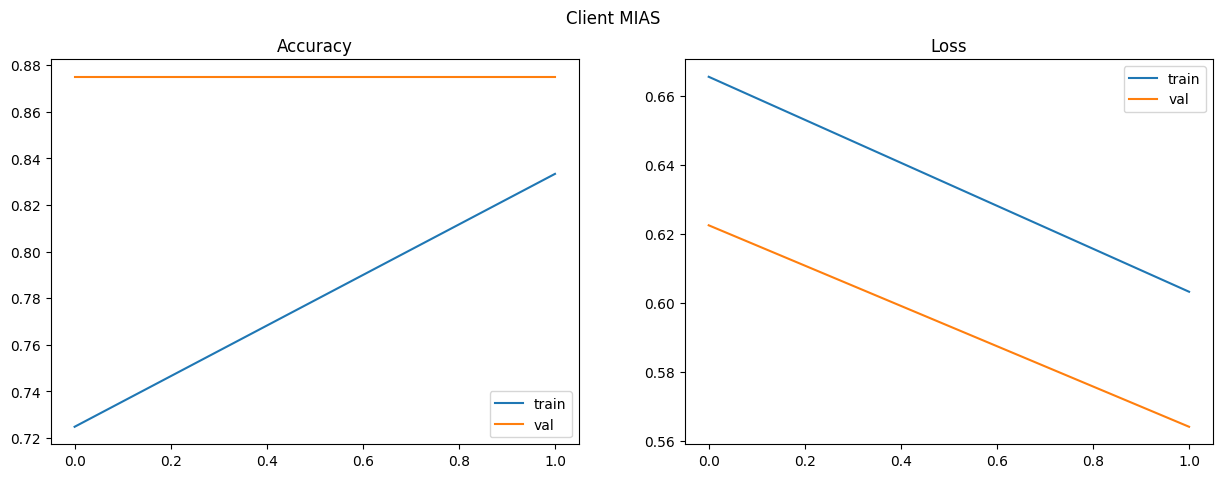

In [2]:

BATCH_SIZE = 16
SIZE_IMAGE = (227, 227)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.Resize(SIZE_IMAGE)])

def pre_process(img):
    '''
    pre-process image before training
    algorithm: CLAHE (Contrast Limited Adaptive Histogram Equalization)
    '''
    img = img.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img)
    return img_clahe

# --- Data ---
class Dataset():
    def __init__(self, path_data, transform=None):
        self.path_data = path_data.upper()
        self.df = pd.read_csv(f'dataset/{self.path_data}-ROI-Mammography/description.csv')
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = f'dataset/{self.path_data}-ROI-Mammography/{self.df.iloc[index].Path_save}'
        image = cv2.imread(image_path, 0)
        if self.transform:
            image = pre_process(image)
            image = self.transform(image)
        label = self.df.iloc[index]['Cancer']
        return image, label
    
def train_test_split(dataset, test_size=0.2):
    s_test = int(test_size * dataset.__len__())
    s_train = dataset.__len__() - s_test
    train_dataset, test_dataset = random_split(dataset, [s_train, s_test])
    return train_dataset, test_dataset
    
def dataloader(train_dataset, test_dataset, batch_size=16):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, test_dataloader

def show_transform(dataloader):
    images, labels = next(iter(dataloader))
    # Reshape and convert images to a NumPy array
    # matplotlib requires images with the shape (height, width, 3)
    images = images.permute(0, 2, 3, 1).numpy()
    # Denormalize
    images = images / 2 + 0.5
    # Create a figure and a grid of subplots
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))
    # Loop over the images and plot them
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(labels[i].item())
        ax.axis("off")
    # Show the plot
    fig.tight_layout()
    plt.show()

def show_origin(dataset):
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axs.flat):
        img = cv2.imread(f'dataset/{dataset.path_data}-ROI-Mammography/{dataset.df.iloc[i].Path_save}', 0)
        ax.imshow(img, cmap='gray')
        ax.set_title(dataset.df.iloc[i].Cancer)
        ax.axis("off")
    fig.tight_layout()
    plt.show()
    
# --- Model ---
# google net
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out1x1, reduce3x3, out3x3, reduce5x5, out5x5, out1x1pool):
        super(InceptionModule, self).__init__()

        # 1x1 convolution branch
        self.branch1x1 = nn.Conv2d(in_channels, out1x1, kernel_size=1)

        # 1x1 convolution followed by 3x3 convolution branch
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, reduce3x3, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduce3x3, out3x3, kernel_size=3, padding=1)
        )

        # 1x1 convolution followed by 5x5 convolution branch
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, reduce5x5, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduce5x5, out5x5, kernel_size=5, padding=2)
        )

        # 3x3 max pooling followed by 1x1 convolution branch
        self.branch1x1pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out1x1pool, kernel_size=1)
        )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch1x1pool = self.branch1x1pool(x)
        outputs = [branch1x1, branch3x3, branch5x5, branch1x1pool]
        return torch.cat(outputs, 1)

class GoogLeNet(nn.Module):
    def __init__(self, num_classes=2):
        super(GoogLeNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)

        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)

        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# lenet
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 1280)
        self.fc2 = nn.Linear(1280, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

# --- Training ---
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    loop = tqdm(train_loader, desc='Training')
    for inputs, labels in loop:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += torch.sum(predicted == labels.data).item()
        acc_cur = torch.sum(predicted == labels.data).item()/labels.size(0)
        loop.set_postfix(loss=loss.item(), acc=acc_cur)
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    
    return train_loss, train_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        loop = tqdm(val_loader, desc='Validation')
        for inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += torch.sum(predicted == labels.data).item()
            acc_cur = torch.sum(predicted == labels.data).item()/labels.size(0)
            loop.set_postfix(loss=loss.item(), acc=acc_cur)
    
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    
    return val_loss, val_acc

def fit(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20):
    lst_acc = {'train': [], 'val': []}
    lst_loss = {'train': [], 'val': []}
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        print(c.SUCCESS('Epoch {}/{}'.format(epoch+1, num_epochs)))
        print('-'*50)

        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        print('Train Loss: {:.4f} - Train Acc: {:.4f}'.format(train_loss, train_acc))
        print('Val Loss: {:.4f} - Val Acc: {:.4f}'.format(val_loss, val_acc))
        print('+'*100)

        lst_acc['train'].append(train_acc)
        lst_acc['val'].append(val_acc)
        lst_loss['train'].append(train_loss)
        lst_loss['val'].append(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'result/best_model.pth')
    print(c.SUCCESS('Training and validation completed!'))
    return lst_acc, lst_loss

# --- client ---
class client():
    def __init__(self, name_client, batch_size, model, criterion, optimizer):
        self.name_client = name_client.upper()
        self.df = Dataset(self.name_client, transform)
        self.df_train, self.df_val = train_test_split(self.df)
        self.train_loader, self.val_loader = dataloader(self.df_train, self.df_val, batch_size)
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

    def run(self, epochs=5):
        lst_acc, lst_loss = fit(self.model, self.train_loader, self.val_loader, self.criterion, self.optimizer, device, num_epochs=epochs)
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'Client {self.name_client}')
        plt.subplot(1, 2, 1)
        plt.plot(lst_acc['train'], label='train')
        plt.plot(lst_acc['val'], label='val')
        plt.title('Accuracy')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(lst_loss['train'], label='train')
        plt.plot(lst_loss['val'], label='val')
        plt.title('Loss')
        plt.legend()
        plt.savefig(f'result/{self.name_client}.png')
        plt.show()
    
    def get_summary(self):
        return summary(self.model, (1, 227, 227))
    
    def get_parameters(self):
        return get_parameters(self.model)

model = GoogLeNet(num_classes=2).to(device)
# model = Net().to(device)
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
client1 = client('MIAS', 16, model, criteria, optimizer)
client1.run(2)

In [4]:
summary(model, (1, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 223, 223]             156
         MaxPool2d-2          [-1, 6, 111, 111]               0
            Conv2d-3         [-1, 16, 107, 107]           2,416
         MaxPool2d-4           [-1, 16, 53, 53]               0
            Linear-5                  [-1, 120]       5,393,400
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 2]             170
Total params: 5,406,306
Trainable params: 5,406,306
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.20
Forward/backward pass size (MB): 4.58
Params size (MB): 20.62
Estimated Total Size (MB): 25.40
----------------------------------------------------------------


In [ ]:
dt = Dataset('MIAS', transform)
dt_train, dt_val = train_test_split(dt)
train_loader, val_loader = dataloader(dt_train, dt_val)
lst_loss, lst_acc = fit(model, train_loader, val_loader, criteria, optimizer, device, num_epochs=2)
lst_loss, lst_acc

Validation: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s, acc=1, loss=0.596]   


Epoch 1/2
Train Loss: 0.6421 - Train Acc: 0.8411
Val Loss: 0.6280 - Val Acc: 0.8438
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s, acc=1, loss=0.563]    

Epoch 2/2
Train Loss: 0.6173 - Train Acc: 0.8411
Val Loss: 0.6068 - Val Acc: 0.8438
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Training and validation completed!


({'train': [tensor(0.8411, device='cuda:0'), tensor(0.8411, device='cuda:0')],
  'val': [tensor(0.8438, device='cuda:0'), tensor(0.8438, device='cuda:0')]},
 {'train': [0.6420671273680294, 0.6172880214803359],
  'val': [0.6279506683349609, 0.6067896783351898]})

# Step 2: Federated Learning with Flower

## Updating model parameters

In [87]:
def get_parameters(net):
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

## Implementing a Flower client

In [88]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

## Using the Virtual Client Engine

In [93]:
def client_fn(name_client: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(device)

    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    train_loader, test_loader = Dataloader(path_data=f'dataset/{name_client.upper()}-ROI-Mammography', transform=transform, batch_size=BATCH_SIZE)

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, train_loader, test_loader)

## Starting the training

In [94]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if device.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-05-25 15:53:13,451 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-05-25 15:53:17,626	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-05-25 15:53:19,083 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2245252300.0, 'CPU': 8.0, 'memory': 4490504603.0, 'node:192.168.10.29': 1.0}
INFO flwr 2023-05-25 15:53:19,084 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-25 15:53:19,085 | server.py:273 | Requesting initial parameters from one random client
ERROR flwr 2023-05-25 15:53:21,561 | ray_client_proxy.py:72 | ray::launch_and_get_parameters() (pid=20505, ip=192.168.10.29)
  File "/home/quachnam/.local/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 135, in launch_and_get_parameters
    client: Client = _create_client(client_fn, cid)
  File "/home/quachnam/.local/lib/python3.10/site-packages/flwr/simulation/ray_tran

RayTaskError(FileNotFoundError): [36mray::launch_and_get_parameters()[39m (pid=20505, ip=192.168.10.29)
  File "/home/quachnam/.local/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 135, in launch_and_get_parameters
    client: Client = _create_client(client_fn, cid)
  File "/home/quachnam/.local/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 168, in _create_client
    client_like: ClientLike = client_fn(cid)
  File "/tmp/ipykernel_6444/803655287.py", line 9, in client_fn
  File "/tmp/ipykernel_6444/3807832444.py", line 35, in Dataloader
  File "/tmp/ipykernel_6444/3807832444.py", line 17, in __init__
  File "/home/quachnam/.local/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 912, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/home/quachnam/.local/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 577, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/home/quachnam/.local/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1407, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/home/quachnam/.local/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1661, in _make_engine
    self.handles = get_handle(
  File "/home/quachnam/.local/lib/python3.10/site-packages/pandas/io/common.py", line 859, in get_handle
    handle = open(
FileNotFoundError: [Errno 2] No such file or directory: 'dataset/0-ROI-Mammography/description.csv'

## Behind the scenes

## Where’s the accuracy?

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

# test

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 224, 224]              60
              ReLU-2          [-1, 6, 224, 224]               0
         MaxPool2d-3          [-1, 6, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             880
              ReLU-5         [-1, 16, 112, 112]               0
         MaxPool2d-6           [-1, 16, 56, 56]               0
            Conv2d-7           [-1, 32, 56, 56]           4,640
              ReLU-8           [-1, 32, 56, 56]               0
         MaxPool2d-9           [-1, 32, 28, 28]               0
           Linear-10                  [-1, 120]       3,010,680
             ReLU-11                  [-1, 120]               0
           Linear-12                   [-1, 84]          10,164
             ReLU-13                   [-1, 84]               0
           Linear-14                   

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import cv2
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split

import torch.nn as nn
import torch.nn.functional as F
import flwr as fl
import multiprocessing as mp
import color
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cores = mp.cpu_count()
c = color.clr()
print(c.SUCCESS('Day:'), datetime.datetime.now())
print(c.SUCCESS('Device:'), device)
print(c.SUCCESS('Core:'), cores)

def pre_process(img):
    img = img.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img)
    return img_clahe
# --- Data ---
class Dataset():
    def __init__(self, path_data, transform=None):
        self.path_data = path_data
        self.df = pd.read_csv(f'{self.path_data}/description.csv')
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = f'{self.path_data}/{self.df.iloc[index].Path_save}'
        image = cv2.imread(image_path, 0)
        if self.transform:
            image = pre_process(image)
            image_trans = self.transform(image)#['image']
        else:
            image_trans = image
        label = self.df.iloc[index]['Cancer']
        return image_trans, label
    
def Dataloader(path_data, transform=None, batch_size=16, size_train=0.8):
    dataset = Dataset(path_data=path_data, transform=transform)
    train_size = int(size_train * dataset.__len__())
    test_size = dataset.__len__() - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, test_dataloader

def show_image(dataset):
    img = dataset[0][0].squeeze()
    label = dataset[0][1]
    cv2.imshow(str(label.item()), img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# --- Model ---
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        loop = tqdm(trainloader, desc='Training')
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
            acc_cur = (torch.max(outputs.data, 1)[1] == labels).sum().item()/labels.size(0)
            loop.set_postfix(loss=loss.item(), acc=acc_cur)
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=2)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(name_client) -> FlowerClient:
    net = Net().to(device)
    train_loader, test_loader = Dataloader(path_data=f'dataset/{name_client.upper()}-ROI-Mammography', transform=transform, batch_size=32)
    return FlowerClient(name_client, net, train_loader, test_loader)

transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5), (0.5)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.Resize((227,227))])
cl1 = client_fn('mias')
cl1.fit()

Day: 2023-05-25 10:15:12.184021
Device: cpu
Core: 8


In [2]:
f = open('result/best_model.pth', 'rb')
# best_model = pickle.load(f)
data = f.readlines()
f.close()
data

[b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x13\x00\x0f\x00best_model/data.pklFB\x0b\x00ZZZZZZZZZZZ\x80\x02ccollections\n',
 b'OrderedDict\n',
 b'q\x00)Rq\x01(X\x0c\x00\x00\x00conv1.weightq\x02ctorch._utils\n',
 b'_rebuild_tensor_v2\n',
 b'q\x03((X\x07\x00\x00\x00storageq\x04ctorch\n',
 b'FloatStorage\n',
 b'q\x05X\x01\x00\x00\x000q\x06X\x06\x00\x00\x00cuda:0q\x07M@\x0ctq\x08QK\x00(K@K\x01K\x07K\x07tq\t(K1K1K\x07K\x01tq\n',
 b'\x89h\x00)Rq\x0btq\x0cRq\rX\n',
 b'\x00\x00\x00conv1.biasq\x0eh\x03((h\x04h\x05X\x01\x00\x00\x001q\x0fX\x06\x00\x00\x00cuda:0q\x10K@tq\x11QK\x00K@\x85q\x12K\x01\x85q\x13\x89h\x00)Rq\x14tq\x15Rq\x16X\x0c\x00\x00\x00conv2.weightq\x17h\x03((h\x04h\x05X\x01\x00\x00\x002q\x18X\x06\x00\x00\x00cuda:0q\x19M\x00\x10tq\x1aQK\x00(K@K@K\x01K\x01tq\x1b(K@K\x01K\x01K\x01tq\x1c\x89h\x00)Rq\x1dtq\x1eRq\x1fX\n',
 b'\x00\x00\x00conv2.biasq h\x03((h\x04h\x05X\x01\x00\x00\x003q!X\x06\x00\x00\x00cuda:0q"K@tq#QK\x00K@\x85q$K\x0

In [3]:
# load the model
model = GoogLeNet(num_classes=2).to(device)
model.load_state_dict(torch.load('result/best_model.pth'))
model.eval()

GoogLeNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): InceptionModule(
    (branch1x1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (branch3x3): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (branch5x5): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (branch1x1pool): Sequential(
      (0): MaxPool2d(kernel_size=3, stride=1, paddin